# VQE-UCCSD NH3

In [17]:
from pyscf import gto, scf, mcscf,cc

mol = gto.M(
    atom = 'N 0.0 0.0 0.0; H -0.114 -0.009 0.990; H -0.437 -0.825 -0.358; H 0.942 -0.010, -0.222',
    basis = '631g')
myhf=scf.RHF(mol).run()

print(mol.nelectron)
norb = myhf.mo_coeff.shape[1]
print(norb)

norb_cas, nele_cas=(4,4)

mycasci=mcscf.CASCI(myhf,norb_cas, nele_cas)
print(mycasci.ncore)

frozen=[]
frozen+=[y for y in range(0,mycasci.ncore)]
frozen+=[y for y in range(mycasci.ncore+norb_cas, len(myhf.mo_coeff))]
mycc=cc.CCSD(myhf,frozen=frozen).run()

from get_amp import uccsd_get_amplitude

#init_params=uccsd_get_amplitude(mycc.t1,mycc.t2,nele_cas,norb_cas)


converged SCF energy = -56.1619016972553
10
15
3
E(CCSD) = -56.16546551675892  E_corr = -0.00356381950364245


In [18]:
import openfermion
import openfermionpyscf
from openfermion.transforms import jordan_wigner, get_fermion_operator

import cudaq
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

# GPU
cudaq.set_target("nvidia", option='mqpu,fp64')


# 1- Classical pre-processing:
geometry=[('N', (0.000,0.000,0.000)), ('H', (-0.114,-0.009,0.990)), ('H', (-0.437,-0.825,-0.358)), ('H', (0.942,-0.010,-0.222))]
basis='631g'
multiplicity=1
charge=0
ncore=mycasci.ncore
#norb_cas, nele_cas = (3,4)

qubit_count=2*norb_cas
electron_count=nele_cas


# Run HF to obtain the HF molecular orbitals and compute the one and two electron integrals
molecule = openfermionpyscf.run_pyscf(openfermion.MolecularData(geometry, basis, multiplicity,charge))

# Generate the active space Hamiltonian 
molecular_hamiltonian = molecule.get_molecular_hamiltonian(
        occupied_indices=range(ncore), active_indices=range(ncore,ncore+norb_cas))

fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

spin_ham=cudaq.SpinOperator(qubit_hamiltonian)

print('Total number of terms in the spin hamiltonian: ',spin_ham.get_term_count())

Total number of terms in the spin hamiltonian:  357


/tmp/ipykernel_1450261/894685578.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  spin_ham=cudaq.SpinOperator(qubit_hamiltonian)


In [19]:
epsilon =np.pi/8

num_qpus = 4

def batched_gradient_function(kernel, parameters, hamiltonian, epsilon): 


    x = np.tile(parameters, (len(parameters),1))

    xplus = x + (np.eye(x.shape[0]) * epsilon)

    xminus = x - (np.eye(x.shape[0]) * epsilon)

    g_plus = []
    g_minus = []
    gradients = []

    qpu_counter = 0 # Iterate over the number of GPU resources available
    for i in range(x.shape[0]): 

        g_plus.append(cudaq.observe_async(kernel,hamiltonian, qubit_count, electron_count, xplus[i], qpu_id = qpu_counter))
        qpu_counter += 1 

        g_minus.append(cudaq.observe_async(kernel, hamiltonian, qubit_count, electron_count, xminus[i], qpu_id = qpu_counter))
        qpu_counter += 1 
        
        if qpu_counter%num_qpus == 0: 
            qpu_counter = 0 
        
    gradients = [(g_plus[i].get().expectation() - g_minus[i].get().expectation()) / (2*epsilon) for i in range(len(g_minus))]

    return gradients

In [20]:
# 2- Quantum computing using UCCSD ansatz
electron_count=nele_cas
qubit_count=2*norb_cas

@cudaq.kernel
def kernel(qubit_num:int, electron_num:int, thetas: list[float]):
        qubits = cudaq.qvector(qubit_num)

        for i in range(electron_num):
                x(qubits[i])

        cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,qubit_count)

In [21]:
#gradient = batched_gradient_function(kernel, x0, spin_ham, epsilon)

exp_vals=[]

def objective_function(parameter_vector: list[float], hamiltonian=spin_ham, kernel=kernel):


    get_result = lambda parameter_vector: cudaq.observe\
        (kernel, hamiltonian, qubit_count, electron_count, parameter_vector).expectation()
    
    cost = get_result(parameter_vector)
    exp_vals.append(cost)
    gradient_vector = batched_gradient_function(kernel, parameter_vector, spin_ham, epsilon)
    
    return cost , gradient_vector

VQE-UCCSD energy=  -56.162000485964356


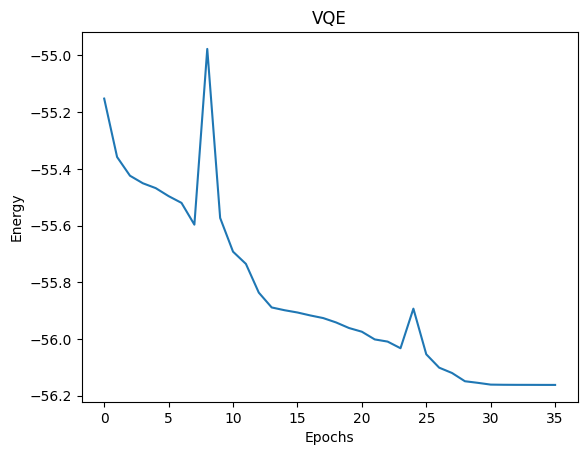

In [22]:
np.random.seed(42)
init_params = np.random.normal(0, 1, parameter_count)

result_vqe=minimize(objective_function,init_params, method='L-BFGS-B', jac=True, tol=1e-8, options={'maxiter': 30})

print('VQE-UCCSD energy= ', result_vqe.fun)

import matplotlib.pyplot as plt

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()